In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.cuda.set_device(0)

In [5]:
PATH = "data/DogBreed/"
sz = 224
arch = resnext101_64
bs = 58

In [6]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
# Get Cross validation indexes 
val_idxs = get_cv_idxs(n)

In [7]:
print(n)
print(val_idxs)
print(len(val_idxs))

10222
[2882 4514 7717 ..., 8922 6774   37]
2044


## Initial Exploration

In [8]:
label_df = pd.read_csv(label_csv)

In [9]:
label_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [10]:
# How many of each breed?
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

id
breed                              
scottish_deerhound              126
maltese_dog                     117
afghan_hound                    116
entlebucher                     115
bernese_mountain_dog            114
shih-tzu                        112
great_pyrenees                  111
pomeranian                      111
basenji                         110
samoyed                         109
airedale                        107
tibetan_terrier                 107
leonberg                        106
cairn                           106
beagle                          105
japanese_spaniel                105
australian_terrier              102
blenheim_spaniel                102
miniature_pinscher              102
irish_wolfhound                 101
lakeland_terrier                 99
saluki                           99
papillon                         96
whippet                          95
siberian_husky                   95
norwegian_elkhound               95
pug                              94
chow                             93
italian_greyhound                92
pembroke                         92
...                             ...
german_short-haired_pointer      75
boxer                            75
bull_mastiff                     75
borzoi                           75
pekinese                         75
cocker_spaniel                   74
american_staffordshire_terrier   74
doberman                         74
brittany_spaniel                 73
malinois                         73
standard_schnauzer               72
flat-coated_retriever            72
redbone                          72
border_collie                    72
curly-coated_retriever           72
kuvasz                           71
chihuahua                        71
soft-coated_wheaten_terrier      71
french_bulldog                   70
vizsla                           70
tibetan_mastiff                  69
german_shepherd                  69
giant_schnauzer                  69
walker_hound                     69
otterhound                       69
golden_retriever                 67
brabancon_griffon                67
komondor                         67
briard                           66
eskimo_dog                       66

[120 rows x 1 columns]

In [11]:
# Enable Data Augmentation and setting up the data
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                        val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

In [12]:
data = get_data(sz, bs)
first_file = PATH+data.trn_ds.fnames[4]
first_file

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

'data/DogBreed/train/00290d3e1fdd27226ba27a8ce248ce85.jpg'

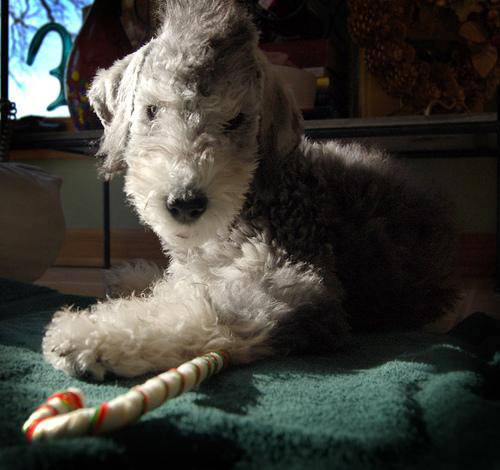

In [13]:
image = PIL.Image.open(first_file)
image

In [14]:
image.size

(500, 470)

In [15]:
#Mapping the file to the size of that file
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [16]:
row_sz, col_sz = list(zip(*size_d.values()))

In [17]:
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

In [18]:
# First 5 row sizes i.e the height
row_sz[:5]

array([500, 500, 500, 500, 500])

(array([ 3023.,  5024.,    92.,    15.,     5.,     3.,    13.,     2.,     0.,     1.]),
 array([   97. ,   413.7,   730.4,  1047.1,  1363.8,  1680.5,  1997.2,  2313.9,  2630.6,  2947.3,  3264. ]),
 <a list of 10 Patch objects>)

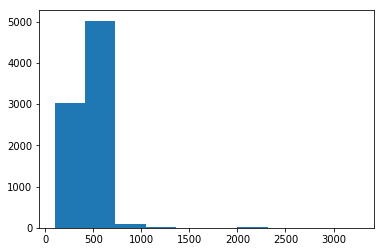

In [19]:
plt.hist(row_sz)

In [20]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

## Initial Model

In [21]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [22]:
#Create precomputed activations
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [23]:
learn.fit(0.01, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.959081   0.416608   0.8909    
    1      0.442616   0.338413   0.911937                    
    2      0.3063     0.301244   0.913894                    
    3      0.242551   0.292653   0.918787                    
    4      0.216241   0.309466   0.915362                    



[array([ 0.30947]), 0.91536203802448435]

In [24]:
learn.precompute = False

In [25]:
learn.fit(0.01, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.249386   0.249376   0.917319  
    1      0.225035   0.245678   0.921233                    
    2      0.210956   0.243354   0.925147                    
    3      0.207664   0.241565   0.926614                    
    4      0.210914   0.240591   0.924168                    



[array([ 0.24059]), 0.92416830328812571]

In [26]:
log_preds = learn.predict()

In [47]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,:])
pred_y = np.argmax(probs, axis=1)
print(pred_y)

[ 19  15   7 ..., 109   3  28]


In [48]:
print(pred_y == data.val_y)

[ True  True  True ...,  True  True  True]


In [118]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows+1, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [119]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=4, figsize=(20,20))

affenpinscher


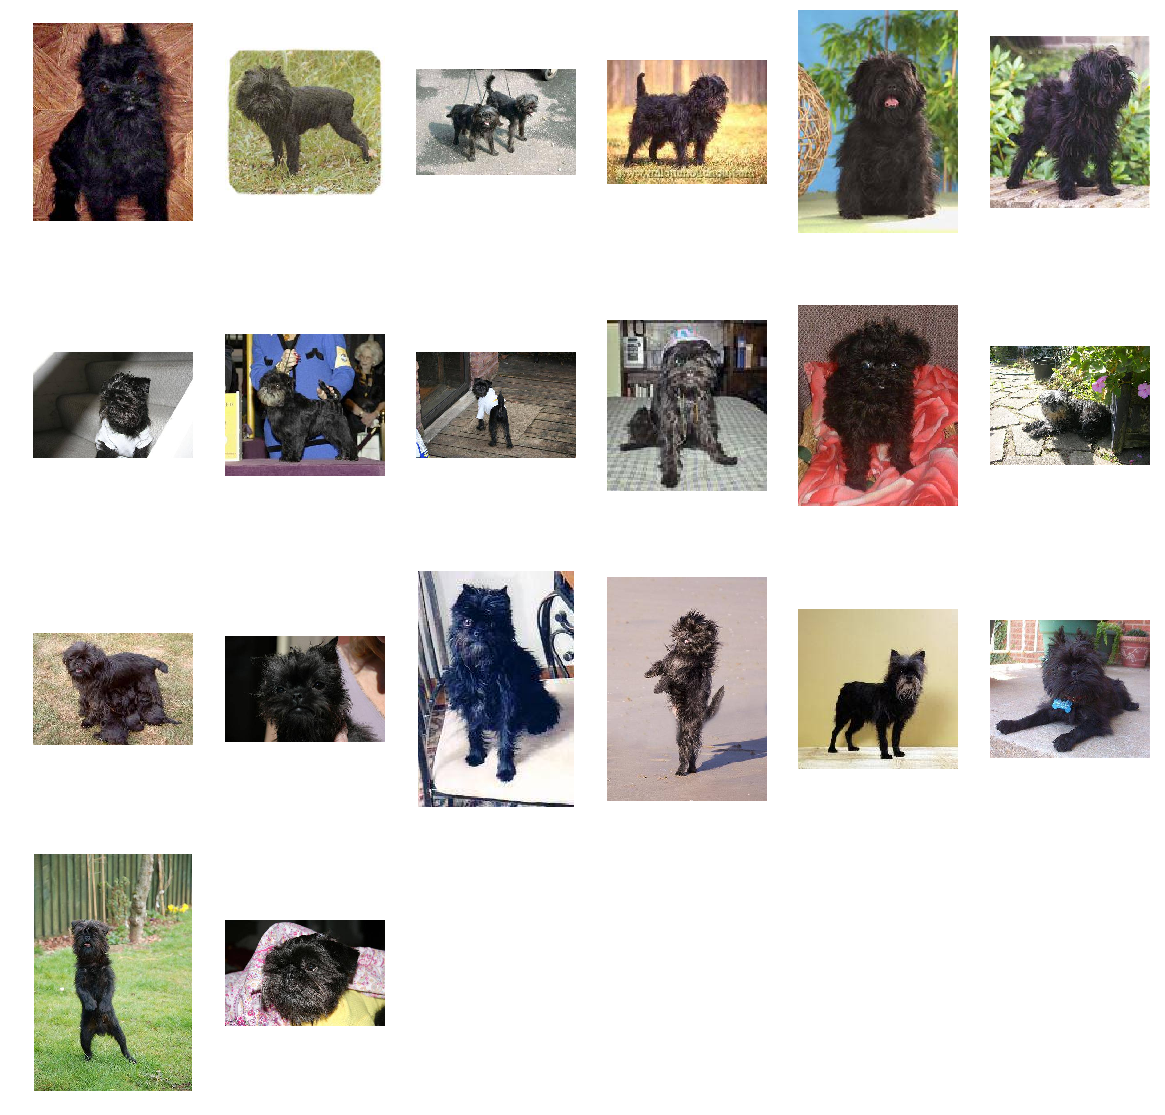

In [120]:
# Showing a few images
idxs_0 = np.argwhere(pred_y == 0)
idxs_0 = idxs_0.T
idxs_0 = np.squeeze(idxs_0)
plot_val_with_title(idxs_0, data.classes[0])

afghan_hound


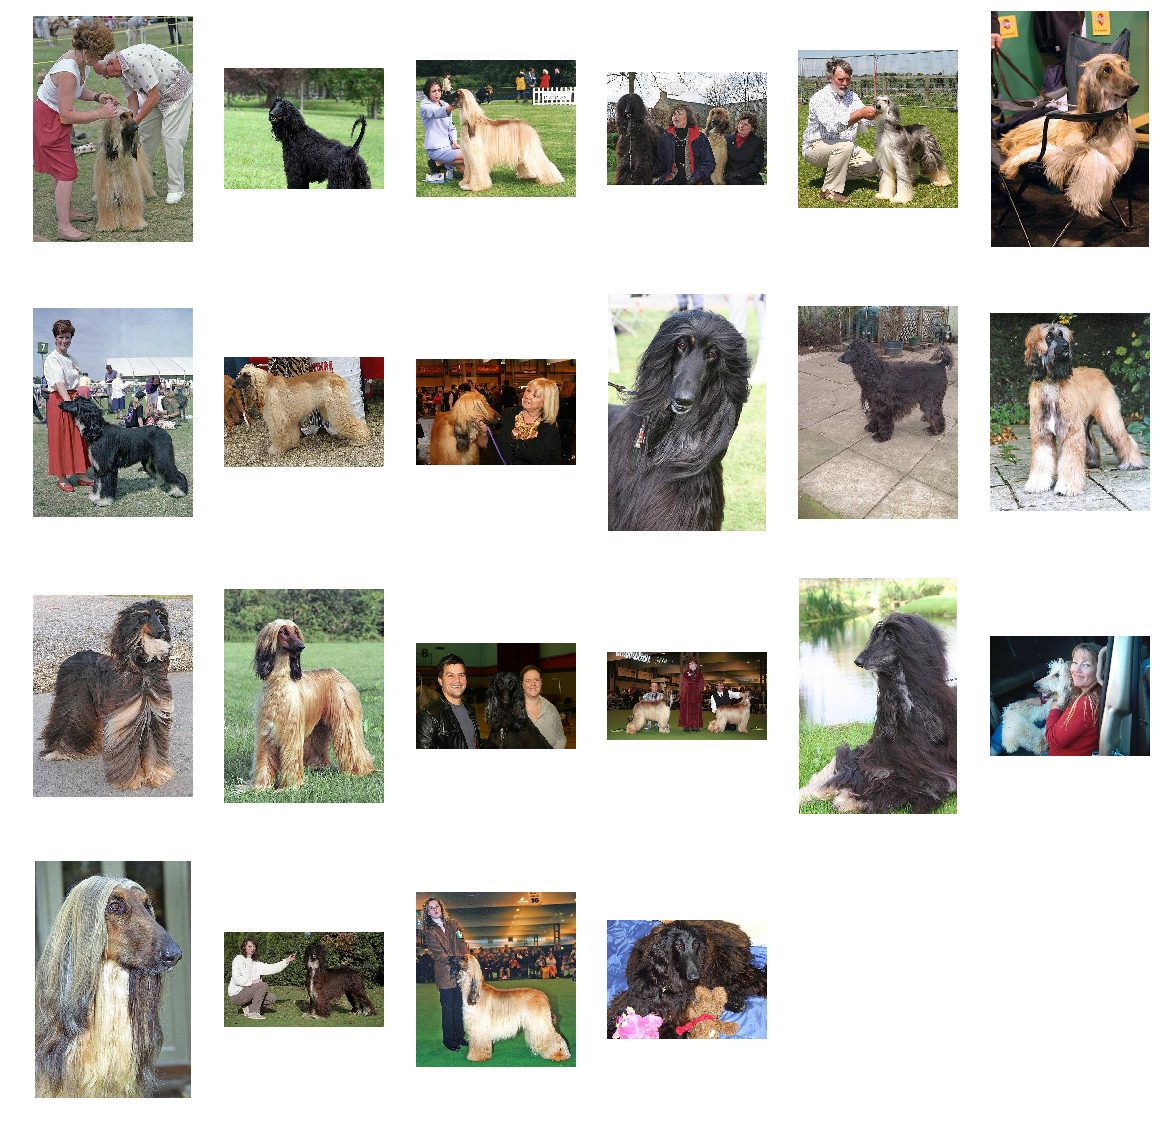

In [121]:
# Showing a few images
idxs_1 = np.argwhere(pred_y == 1)
idxs_1 = np.squeeze(idxs_1.T)
plot_val_with_title(idxs_1, data.classes[1])

african_hunting_dog


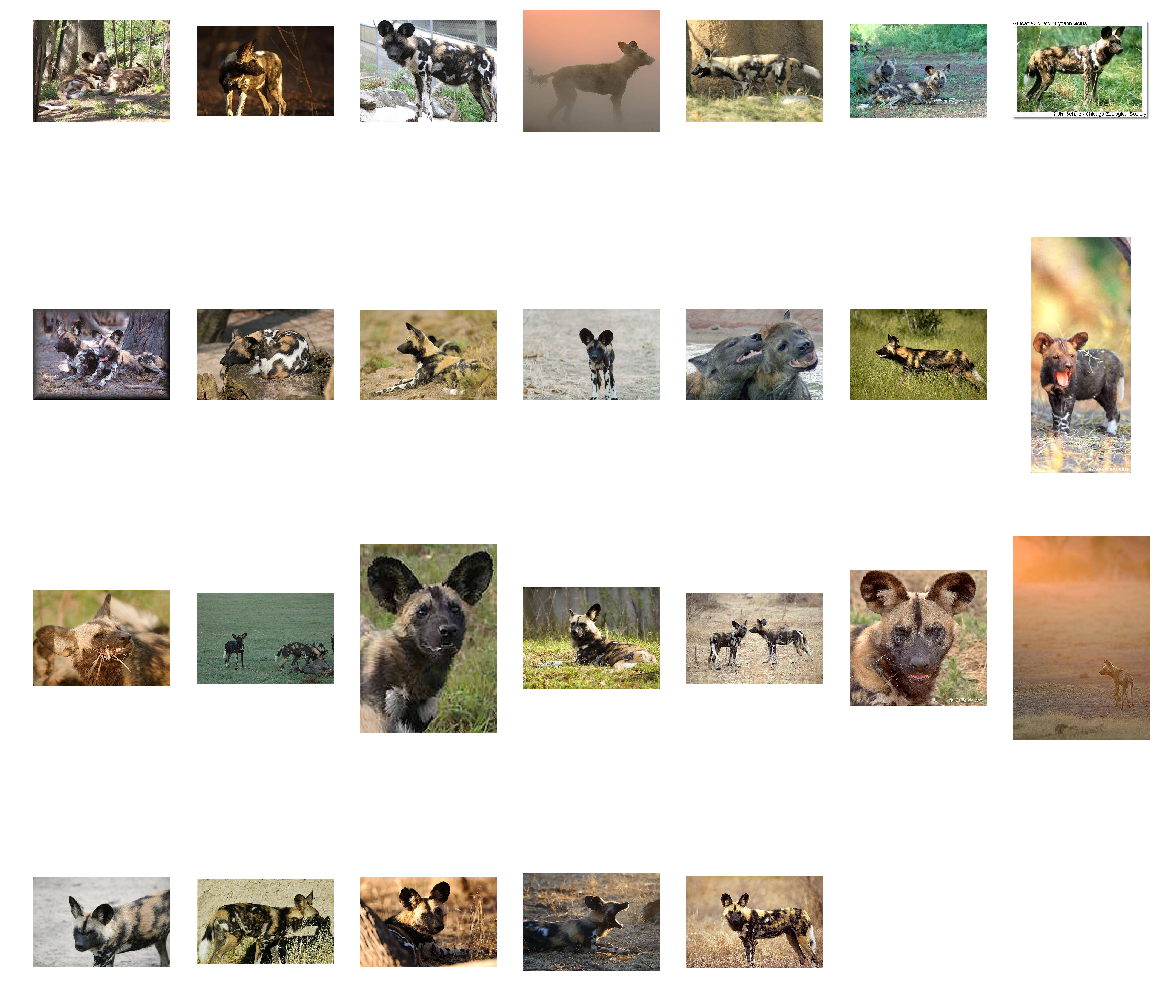

In [122]:
# Showing a few images
idxs_2 = np.argwhere(pred_y == 2)
idxs_2 = np.squeeze(idxs_2.T)
plot_val_with_title(idxs_2, data.classes[2])

## Increase Size

In [123]:
learn.set_data(get_data(299, bs))
learn.freeze()

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [124]:
learn.fit(0.01, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.216413   0.232236   0.924168  
    1      0.197871   0.23152    0.925147                    
    2      0.193737   0.232702   0.922701                    



[array([ 0.2327]), 0.92270058451799963]

In [125]:
#Trying a different Architecture
arch = resnext50

In [126]:
#Create precomputed activations
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 179/179 [00:52<00:00,  3.40it/s]


In [127]:
learn.fit(0.01, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.032756   0.502623   0.882094  
    1      0.505882   0.411517   0.886986                    
    2      0.355572   0.353059   0.8909                      
    3      0.295933   0.348638   0.893346                    
    4      0.222163   0.362193   0.89775                     



[array([ 0.36219]), 0.89774951257117808]

In [128]:
learn.precompute = False

In [129]:
learn.fit(0.01, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.314446   0.313167   0.900196  
    1      0.282344   0.316552   0.899706                    
    2      0.248976   0.303855   0.90411                     
    3      0.249224   0.304563   0.902153                    
    4      0.226034   0.301829   0.903131                    



[array([ 0.30183]), 0.90313111516827471]